In this project, we will build a credit card fraud detection system using an autoencoder.



In [2]:
import numpy as np
import pandas as pd
import os, time, re 
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
color = sns.color_palette()

%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, \
    roc_auc_score

import lightgbm as lgb

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [3]:
data = pd.read_csv("data/credit_card_fraud.csv")
X = data.copy().drop(['Class','Time'],axis=1)
y = data['Class'].copy()

featuresToScale = X.columns
scaler = pp.StandardScaler()

X_scaled = pd.DataFrame( data=scaler.fit_transform(X[featuresToScale]), columns=featuresToScale )

In [4]:
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y , test_size=0.33, random_state=2018, stratify=y )

In [5]:
def anomalyScores( originalDF, reducedDF ):
    """Compute anomaly scores to be the l2 norm of the reconstruction error"""
    loss = np.sum(( np.array(originalDF) - np.array(reducedDF) )**2, axis=1 )
    loss = pd.Series( data=loss, index=originalDF.index )
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [18]:
def plotResults( trueLabels, anomalyScores ):
    preds = pd.concat([trueLabels, anomalyScores],axis=1)
    preds.columns = ['trueLabel','anomalyScore']
    precision, recall, thresholds = precision_recall_curve( preds['trueLabel'],preds['anomalyScore'] )
    average_precision = average_precision_score( preds['trueLabel'], preds['anomalyScore'] )
    plt.step( recall, precision, color='k', alpha=0.7, where='post' )
    plt.fill_between( recall, precision, step='post', alpha=0.3, color='k' )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    
    plt.title("Precision-Recall Curve: Average Precision = {0:0.2f}".format(average_precision))
    
    fpr, tpr, thresholds = roc_curve( preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc( fpr, tpr )
    
    plt.figure()
    plt.plot( fpr, tpr , color='r', lw=2, label='ROC Curve' )
    plt.plot([0,1], [0,1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic: Area under the curve = {0:0.2f}".format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    return preds, average_precision

# Components of an Autoencoder
***
We will build a simple autoencoder, using an input layer, a single hidden layer, and the output layer.

We feed the original feature matrix into the input layer of the autoencoder. Then, we apply the activation function to the input layer to generate the hidden layer. This activation function is called $f$ and represents the _encoder_ portion of the autoencoder. 

The hidden layer represents newly learned representation of the input data. 

Then, we apply an activation function to the hidden layer to reconstruct the original observations. This activation function is called $g$ and represents the decoder part of the autoencoder. The output layer represents the newly reconstructed observations. 

To compute the reconstruction error, we compare the reconstructed observations with the original design matrix. 
# Our First Autoencoder
***
We start with a two-layer autoencoder with a linear activation function for both the encoder and the decoder functions. 

The total number of layers consists of the number of hidden layers plus the output layer. So as we have a single hidden layer and an output layer, we are building a two-layer neural network.

To build this model, we called the _Sequential model API_. The Sequential model is a linear stack of layers, and we will pass the types of layers we want into the model before compiling the model and training on the data. 

After calling the Sequential model, we need to specify the input shape by designating the number of dimensions, which needs to match the number of dimensions in our feature matrix (29 in this case).

We also need to specify the activation function applied to the input layer and the number of nodes we want in the hidden layer. 

We will be creating a **complete autoencoder**. In this kind of autoencoder, the number of nodes in the hidden layer is equal to the number of nodes in the input layer (29).

After we've specified the number of nodes in the layers, we then need to compile the layers. In order to perform the compilation, we have to specify the _loss function_, an _optimizer_ and a list of _metrics_. These are used to guide the learning of the weights, to set the process by which the weights are learned, and a way to evaluate the goodness of the neural network, respectively.

## Loss Function
***
For the **loss function**, we will use the _mean squared error_. 
## Optimizer
***
After each epoch, the neural network readjusts its learned weights to reduce its loss from the previous epoch. The process for learning these weights is set by the optimizer. 

The way in which the weights are adjusted can be controlled, so that the weights are iteratively moved in the direction to reduce the loss function incrementally. A better approach is to move the weights in this direction, but with an added bit of randomness to move the weights stochastically.

We need to adjust the learning rate over the course of training. In earlier epochs, it makes sense to adjust the weights by larger factors, and then to decrease this factor as training goes on. 

The later on during training, the smaller the training weight should be, so an optimizer that is even better than the stochastic gradient descent optimizer is the _Adam optimization algorithm_. The adam optimization algorithm is derived from adaptive moment estimation. This optimizer dynamically sets the learning rate over the course of the training process.

For this optimizer, we need to specify the alpha, the rate at which the weights are updated. Larger values of alpha result in faster initial learning before the learning rate is updated.

In [20]:
model = Sequential()
model.add( Dense( units=29, activation='linear', input_dim=29 ) )
model.add( Dense( units=29, activation='linear'))
model.compile( optimizer='adam',\
             loss='mean_squared_error',
             metrics=['accuracy'] )

In [21]:
num_epochs = 10
batch_size = 32

history = model.fit( x=X_train, y=X_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, X_train), verbose=1 )

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.0829 - acc: 0.9005 - val_loss: 4.5676e-04 - val_acc: 0.9924
Epoch 2/10
190820/190820 [==============================] - 9s 45us/step - loss: 6.6042e-04 - acc: 0.9935 - val_loss: 0.0034 - val_acc: 0.9573
Epoch 3/10
190820/190820 [==============================] - 9s 45us/step - loss: 7.4793e-04 - acc: 0.9948 - val_loss: 0.0014 - val_acc: 0.9856
Epoch 4/10
190820/190820 [==============================] - 9s 45us/step - loss: 6.6960e-04 - acc: 0.9925 - val_loss: 3.4493e-05 - val_acc: 0.9984
Epoch 5/10
190820/190820 [==============================] - 8s 45us/step - loss: 6.8597e-04 - acc: 0.9941 - val_loss: 1.3986e-04 - val_acc: 0.9938
Epoch 6/10
190820/190820 [==============================] - 9s 45us/step - loss: 7.2162e-04 - acc: 0.9958 - val_loss: 6.6680e-06 - val_acc: 0.9991
Epoch 7/10
190820/190820 [==============================] - 9s 45us/step - los

We see the autoencoder has reconstructed the original feature matrix exactly, by simply memorizing the inputs. 

Our autoencoder is meant to learn a new representation that captures the salient information in the original data, while dropping less relevant information. Simply memorizing the inputs basically means we learned a representation of the identity function, and will not result in any representation learning.

# Evaluating on the Test Set
***
We can use the test set to evaluate how well the autoencoder can identify the fraud in the credit card transactions dataset.

93987/93987 [==============================] - 1s 14us/step


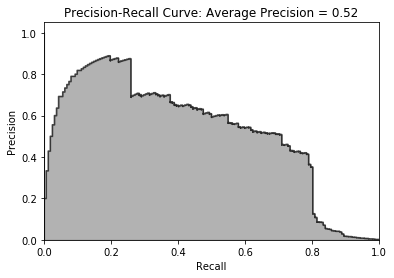

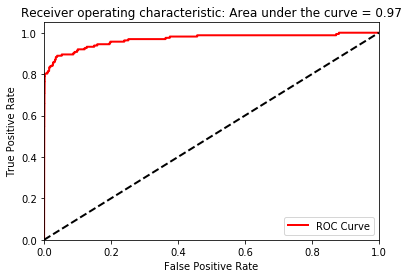

In [22]:
predictions = model.predict( X_test, verbose=1 )
AutoEncoderAnomalyScores = anomalyScores( X_test, predictions)
preds, avgPrecision = plotResults( y_test, AutoEncoderAnomalyScores )

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.0798 - acc: 0.9000 - val_loss: 2.5672e-04 - val_acc: 0.9950
Epoch 2/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.0013 - acc: 0.9936 - val_loss: 2.0429e-06 - val_acc: 0.9995
Epoch 3/10
190820/190820 [==============================] - 9s 46us/step - loss: 4.2833e-04 - acc: 0.9956 - val_loss: 3.0581e-05 - val_acc: 0.9970
Epoch 4/10
190820/190820 [==============================] - 9s 46us/step - loss: 7.6875e-04 - acc: 0.9921 - val_loss: 7.2758e-04 - val_acc: 0.9874
Epoch 5/10
190820/190820 [==============================] - 9s 46us/step - loss: 6.3082e-04 - acc: 0.9932 - val_loss: 4.4093e-06 - val_acc: 0.9992
Epoch 6/10
190820/190820 [==============================] - 9s 46us/step - loss: 3.5622e-04 - acc: 0.9946 - val_loss: 1.1266e-04 - val_acc: 0.9947
Epoch 7/10
190820/190820 [==============================] - 9s 46us/step -

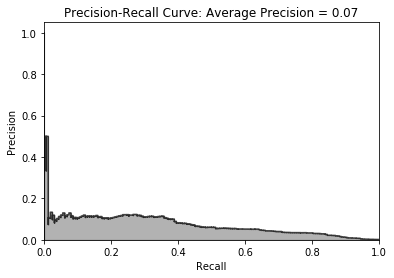

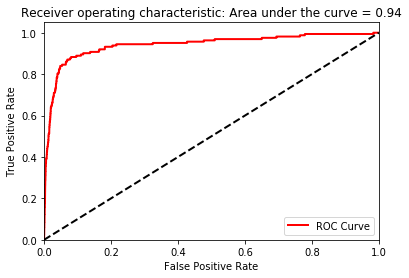

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.0698 - acc: 0.9076 - val_loss: 0.0016 - val_acc: 0.9902
Epoch 2/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.0016 - acc: 0.9897 - val_loss: 0.0045 - val_acc: 0.9684
Epoch 3/10
190820/190820 [==============================] - 9s 46us/step - loss: 6.3414e-04 - acc: 0.9944 - val_loss: 3.5480e-06 - val_acc: 0.9993
Epoch 4/10
190820/190820 [==============================] - 9s 46us/step - loss: 6.5406e-04 - acc: 0.9946 - val_loss: 0.0068 - val_acc: 0.9620
Epoch 5/10
190820/190820 [==============================] - 9s 46us/step - loss: 5.5831e-04 - acc: 0.9937 - val_loss: 1.5764e-04 - val_acc: 0.9976
Epoch 6/10
190820/190820 [==============================] - 9s 46us/step - loss: 4.5988e-04 - acc: 0.9947 - val_loss: 3.9408e-06 - val_acc: 0.9997
Epoch 7/10
190820/190820 [==============================] - 9s 46us/step - loss: 5.587

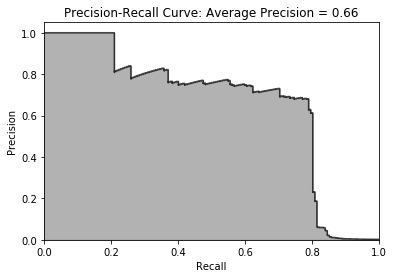

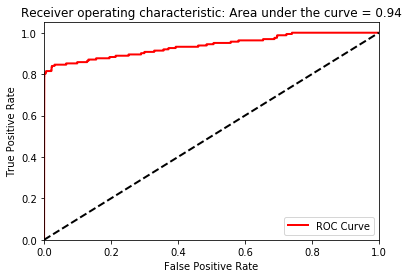

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 50us/step - loss: 0.0697 - acc: 0.9069 - val_loss: 0.0016 - val_acc: 0.9863
Epoch 2/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0012 - acc: 0.9894 - val_loss: 5.1395e-06 - val_acc: 0.9993
Epoch 3/10
190820/190820 [==============================] - 9s 47us/step - loss: 9.7733e-04 - acc: 0.9938 - val_loss: 2.6747e-05 - val_acc: 0.9979
Epoch 4/10
190820/190820 [==============================] - 9s 47us/step - loss: 6.8354e-04 - acc: 0.9953 - val_loss: 1.9556e-06 - val_acc: 0.9992
Epoch 5/10
190820/190820 [==============================] - 9s 46us/step - loss: 5.2858e-04 - acc: 0.9937 - val_loss: 1.3953e-06 - val_acc: 0.9994
Epoch 6/10
190820/190820 [==============================] - 9s 47us/step - loss: 4.5645e-04 - acc: 0.9952 - val_loss: 4.2445e-07 - val_acc: 0.9998
Epoch 7/10
190820/190820 [==============================] - 9s 46us/step - los

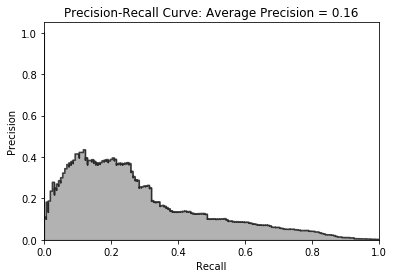

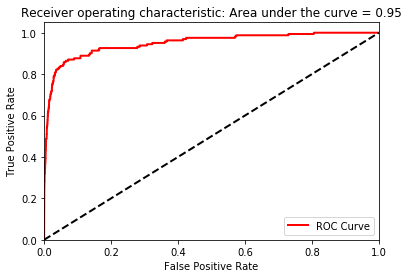

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 51us/step - loss: 0.0956 - acc: 0.8744 - val_loss: 0.0027 - val_acc: 0.9796
Epoch 2/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0012 - acc: 0.9901 - val_loss: 7.0247e-07 - val_acc: 0.9997
Epoch 3/10
190820/190820 [==============================] - 9s 48us/step - loss: 6.4644e-04 - acc: 0.9943 - val_loss: 1.5672e-05 - val_acc: 0.9982
Epoch 4/10
190820/190820 [==============================] - 9s 48us/step - loss: 7.7601e-04 - acc: 0.9941 - val_loss: 6.1227e-05 - val_acc: 0.9973
Epoch 5/10
190820/190820 [==============================] - 9s 48us/step - loss: 6.2177e-04 - acc: 0.9953 - val_loss: 5.0229e-06 - val_acc: 0.9991
Epoch 6/10
190820/190820 [==============================] - 9s 47us/step - loss: 6.0510e-04 - acc: 0.9945 - val_loss: 0.0048 - val_acc: 0.9878
Epoch 7/10
190820/190820 [==============================] - 9s 47us/step - loss: 

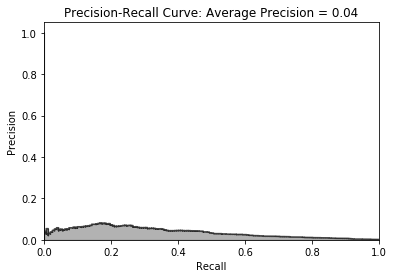

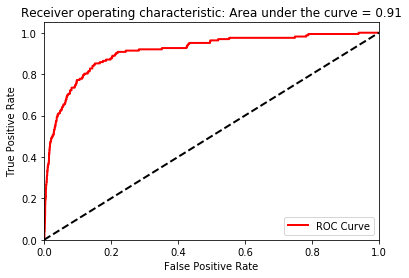

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.0745 - acc: 0.9104 - val_loss: 2.0333e-04 - val_acc: 0.9954
Epoch 2/10
190820/190820 [==============================] - 9s 49us/step - loss: 8.1150e-04 - acc: 0.9928 - val_loss: 3.5219e-04 - val_acc: 0.9967
Epoch 3/10
190820/190820 [==============================] - 9s 48us/step - loss: 5.9097e-04 - acc: 0.9945 - val_loss: 9.8476e-05 - val_acc: 0.9971
Epoch 4/10
190820/190820 [==============================] - 9s 48us/step - loss: 8.5565e-04 - acc: 0.9939 - val_loss: 3.8500e-04 - val_acc: 0.9960
Epoch 5/10
190820/190820 [==============================] - 9s 49us/step - loss: 4.6162e-04 - acc: 0.9950 - val_loss: 0.0011 - val_acc: 0.9959
Epoch 6/10
190820/190820 [==============================] - 9s 48us/step - loss: 5.9884e-04 - acc: 0.9951 - val_loss: 1.7966e-04 - val_acc: 0.9950
Epoch 7/10
190820/190820 [==============================] - 9s 49us/step 

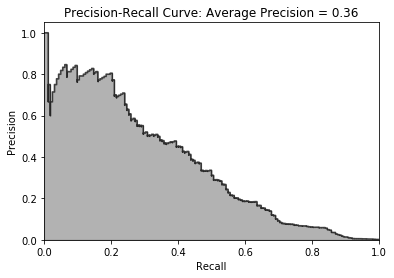

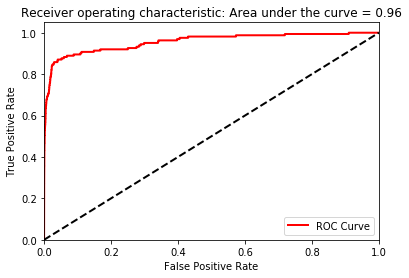

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.0654 - acc: 0.9081 - val_loss: 0.0013 - val_acc: 0.9868
Epoch 2/10
190820/190820 [==============================] - 9s 50us/step - loss: 8.4030e-04 - acc: 0.9919 - val_loss: 5.9373e-06 - val_acc: 0.9989
Epoch 3/10
190820/190820 [==============================] - 9s 50us/step - loss: 7.6820e-04 - acc: 0.9935 - val_loss: 5.2571e-04 - val_acc: 0.9935
Epoch 4/10
190820/190820 [==============================] - 9s 49us/step - loss: 7.1442e-04 - acc: 0.9937 - val_loss: 5.6610e-05 - val_acc: 0.9959
Epoch 5/10
190820/190820 [==============================] - 10s 50us/step - loss: 5.3099e-04 - acc: 0.9940 - val_loss: 1.9722e-05 - val_acc: 0.9981
Epoch 6/10
190820/190820 [==============================] - 9s 49us/step - loss: 5.4663e-04 - acc: 0.9941 - val_loss: 3.9290e-06 - val_acc: 0.9989
Epoch 7/10
190820/190820 [==============================] - 9s 49us/step

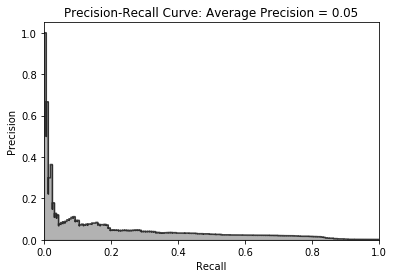

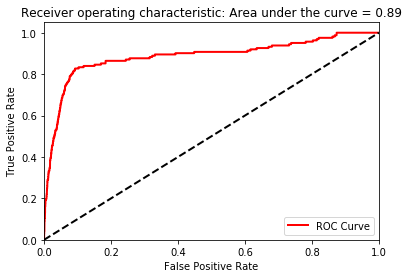

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.0788 - acc: 0.8996 - val_loss: 0.0028 - val_acc: 0.9792
Epoch 2/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.0019 - acc: 0.9876 - val_loss: 7.2058e-05 - val_acc: 0.9969
Epoch 3/10
190820/190820 [==============================] - 9s 47us/step - loss: 8.4984e-04 - acc: 0.9931 - val_loss: 5.2914e-07 - val_acc: 0.9996
Epoch 4/10
190820/190820 [==============================] - 9s 46us/step - loss: 7.7560e-04 - acc: 0.9947 - val_loss: 2.4154e-04 - val_acc: 0.9941
Epoch 5/10
190820/190820 [==============================] - 8s 43us/step - loss: 4.0210e-04 - acc: 0.9948 - val_loss: 2.2031e-04 - val_acc: 0.9916
Epoch 6/10
190820/190820 [==============================] - 8s 40us/step - loss: 6.0824e-04 - acc: 0.9935 - val_loss: 9.3889e-04 - val_acc: 0.9857
Epoch 7/10
190820/190820 [==============================] - 8s 40us/step - lo

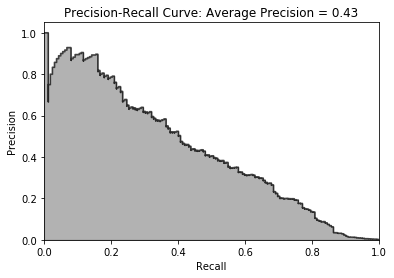

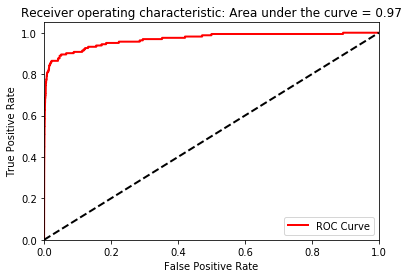

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.0753 - acc: 0.8960 - val_loss: 0.0017 - val_acc: 0.9870
Epoch 2/10
190820/190820 [==============================] - 8s 40us/step - loss: 0.0013 - acc: 0.9910 - val_loss: 9.9521e-07 - val_acc: 0.9995
Epoch 3/10
190820/190820 [==============================] - 8s 40us/step - loss: 6.3753e-04 - acc: 0.9933 - val_loss: 3.7053e-05 - val_acc: 0.9975
Epoch 4/10
190820/190820 [==============================] - 8s 40us/step - loss: 6.3316e-04 - acc: 0.9948 - val_loss: 1.5618e-04 - val_acc: 0.9953
Epoch 5/10
190820/190820 [==============================] - 8s 41us/step - loss: 4.6810e-04 - acc: 0.9939 - val_loss: 2.0179e-05 - val_acc: 0.9973
Epoch 6/10
190820/190820 [==============================] - 8s 40us/step - loss: 6.5548e-04 - acc: 0.9953 - val_loss: 1.0803e-07 - val_acc: 0.9998
Epoch 7/10
190820/190820 [==============================] - 8s 40us/step - los

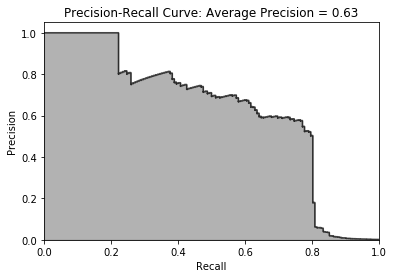

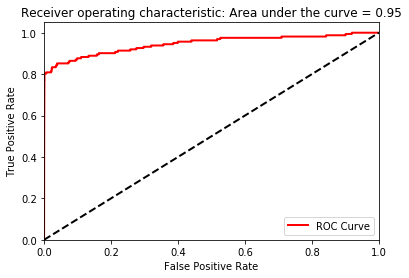

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 51us/step - loss: 0.0888 - acc: 0.8797 - val_loss: 0.0013 - val_acc: 0.9890
Epoch 2/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.0011 - acc: 0.9896 - val_loss: 1.1213e-04 - val_acc: 0.9952
Epoch 3/10
190820/190820 [==============================] - 8s 43us/step - loss: 5.6755e-04 - acc: 0.9938 - val_loss: 6.4596e-05 - val_acc: 0.9967
Epoch 4/10
190820/190820 [==============================] - 8s 43us/step - loss: 7.5080e-04 - acc: 0.9929 - val_loss: 0.0011 - val_acc: 0.9771
Epoch 5/10
190820/190820 [==============================] - 8s 43us/step - loss: 5.0583e-04 - acc: 0.9947 - val_loss: 2.4901e-04 - val_acc: 0.9953
Epoch 6/10
190820/190820 [==============================] - 9s 48us/step - loss: 3.6306e-04 - acc: 0.9956 - val_loss: 0.0032 - val_acc: 0.9721
Epoch 7/10
190820/190820 [==============================] - 10s 50us/step - loss: 6.2

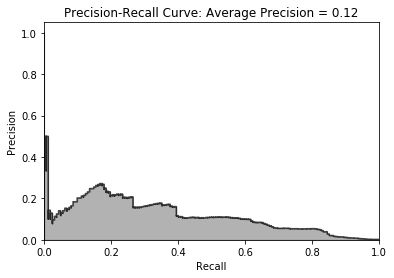

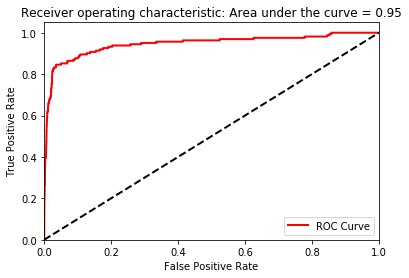

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.1100 - acc: 0.8660 - val_loss: 0.0035 - val_acc: 0.9807
Epoch 2/10
190820/190820 [==============================] - 10s 50us/step - loss: 0.0015 - acc: 0.9873 - val_loss: 0.0014 - val_acc: 0.9984
Epoch 3/10
190820/190820 [==============================] - 9s 48us/step - loss: 6.4032e-04 - acc: 0.9936 - val_loss: 5.7223e-04 - val_acc: 0.9859
Epoch 4/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0010 - acc: 0.9923 - val_loss: 0.0070 - val_acc: 0.9844
Epoch 5/10
190820/190820 [==============================] - 9s 49us/step - loss: 4.5635e-04 - acc: 0.9952 - val_loss: 1.8522e-05 - val_acc: 0.9978
Epoch 6/10
190820/190820 [==============================] - 9s 47us/step - loss: 6.8995e-04 - acc: 0.9945 - val_loss: 9.8374e-06 - val_acc: 0.9989
Epoch 7/10
190820/190820 [==============================] - 9s 47us/step - loss: 4.3239e-

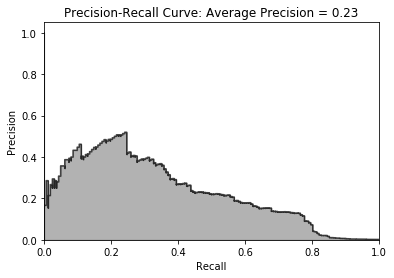

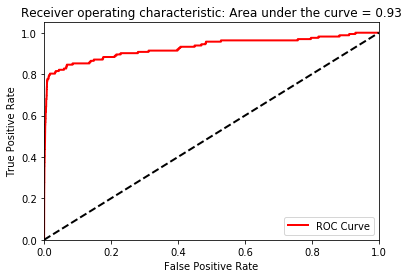

In [23]:
test_scores = []
for i in range(0,10):
    # call neural network API
    model = Sequential()
    # apply linear activation function to input layer, hidden layer has 29 nodes and input layer has 29 nodes
    model.add( Dense( units=29, activation='linear', input_dim=29 ) )
    # apply linear activation function to the hidden layer and generate an output layer with 29 ndoes
    model.add( Dense( units=29, activation='linear' ) )
    model.compile( optimizer='adam', loss='mean_squared_error', metrics=['accuracy'] )
    
    num_epochs = 10
    batch_size = 32

    history = model.fit( x=X_train, y=X_train, epochs=num_epochs, batch_size=batch_size, shuffle=True, validation_data=(X_train, X_train), verbose=1 )
    predictions = model.predict( X_test, verbose=1 )
    AutoEncoderAnomalyScores = anomalyScores( X_test, predictions)
    preds, avgPrecision = plotResults( y_test, AutoEncoderAnomalyScores )
    test_scores.append( avgPrecision )

In [24]:
print(np.mean(test_scores))

0.27573518929270924
